In [747]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
np.random.seed(0)

# Data

In [748]:
def generate_line(n, sign = "+"):
    t = torch.linspace(-3, 3, n)
    x = t.view(-1, 1)
    if sign == "+":
        y = t.view(-1, 1)
    else:
        y = -t.view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)


def generate_line_small(n, sign = "+"):
    t = torch.linspace(-1, 1, n)
    x = t.view(-1, 1)
    if sign == "+":
        y = t.view(-1, 1)
    else:
        y = -t.view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_parabola(n, sign = "+"):
    t = torch.linspace(-3, 3, n)
    x = (t).view(-1, 1)
    if sign == "+":
        y = (t**2).view(-1, 1)
    else:
        y = -(t**2).view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_circle(n, r = 1):
    t = torch.linspace(-3*torch.pi, 3 * torch.pi, n)
    x = (r * torch.cos(t)).view(-1, 1)
    y = (r * torch.sin(t)).view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)


def generate_sphere(n, a = 1, b = 1, c = 1):
    t1 = torch.linspace(0, 1*torch.pi, n)
    t2 = torch.linspace(0, 2*torch.pi, n)
    grid_t1, grid_t2 = torch.meshgrid((t1, t2), indexing='ij')
    t = torch.stack((grid_t1, grid_t2), dim=-1).reshape(-1, 2).to(device)
    x = (a * torch.sin(grid_t1) * torch.cos(grid_t2)).view(-1, 1)
    y = (b * torch.sin(grid_t1) *  torch.sin(grid_t2)).view(-1, 1)
    z = (c * torch.cos(grid_t1)).view(-1, 1)
    return torch.cat((x, y, z), dim=1).unsqueeze(0)

def generate_3D_ellipse(n, r1 = 1, r2 = 0.5):
    t = torch.linspace(-3*torch.pi/2, 3 * torch.pi/2, n)
    x = (r1 * torch.cos(t)).view(-1, 1)
    y = (r2 * torch.sin(t)).view(-1, 1)
    z = (0 * torch.sin(t)).view(-1, 1)
    return torch.cat((x, y, z), dim=1).unsqueeze(0)


def generate_ellipse(n, r1 = 1, r2 = 0.5):
    t = torch.linspace(-2*torch.pi/2, 10 * torch.pi/2, n)
    x = (r1 * torch.cos(t)).view(-1, 1)
    y = (r2 * torch.sin(t)).view(-1, 1)
    return torch.cat((x, y), dim=1).unsqueeze(0)

def generate_data(n, sign = "+"):
    line = generate_line(n, sign)
    line2 = generate_line_small(n, sign = '-')
    parabola = generate_parabola(n, sign)
    circle = generate_circle(n)
    circle1 = generate_circle(n, r=2)
    el = generate_ellipse(n, r1 = 0.5, r2 = 1)
    e2 = generate_ellipse(n, r1 = 0.5, r2 = 1)
    return torch.concat((el, circle), dim=0)

def plot_data(data, mode = '3D'):
    data = data.to("cpu").detach().numpy()
    
    if mode == '3D':
        fig = plt.figure(figsize=(15, 5))  # Create a wide figure to accommodate three subplots
        
        # First subplot
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.view_init(elev=20, azim=30)  # Set the viewing angle
        for i in range(data.shape[0]):
            ax1.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax1.set_title('View 1')

        # Second subplot
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        ax2.view_init(elev=40, azim=60)  # Change the viewing angle
        for i in range(data.shape[0]):
            ax2.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax2.set_title('View 2')

        # Third subplot
        ax3 = fig.add_subplot(133, projection='3d')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_zlabel('Z')
        ax3.view_init(elev=60, azim=90)  # Change the viewing angle again
        for i in range(data.shape[0]):
            ax3.scatter(data[i, :, 0], data[i, :, 1], data[i, :, 2], alpha=1.0, s=0.5)
        ax3.set_title('View 3')

        plt.tight_layout()
        plt.show()
    else:
        for i in range(data.shape[0]):
            plt.scatter(data[i, :, 0], data[i, :, 1], s=1.5)
        plt.show()

# fIMLE Helpers

In [749]:
class H_theta(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(H_theta, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.fc(x)
    

def generate_NN_latent_functions(num_samples, xdim=1, zdim=2, lambda_value=1):
    class NN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 100)
            self.fc2 = nn.Linear(100, 50)
            self.fc3 = nn.Linear(50, 50)
            self.fc4 = nn.Linear(50, output_dim)
        
        def forward(self, x):
            x = (self.fc1(x))
            x = (self.fc2(x))
            x = (self.fc3(x))
            x = self.fc4(x)
            return x

    #  weight initialization function
    def weights_init_normal(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight, gain = 0.5)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    #  neural networks
    networks = []
    for _ in range(num_samples):
        net = NN(xdim, zdim)
        net.apply(weights_init_normal)
        networks.append(net)
    return networks

def find_nns(Y, G):
    min_distance = float('inf')
    min_idx = -1

    for i in range(G.shape[0]):
        distance = torch.sum(((Y - G[i]) ** 2), dim=1).mean(dim=0)
        if distance < min_distance:
            min_distance = distance
            min_idx = i
    return min_idx

def f_loss(Y, G):
    weighted_diffs = (G - Y)**2
    diffs = torch.sum(weighted_diffs, dim=2)
    total_loss = diffs.mean(dim=1).mean(dim=0)
    return total_loss

# fIMLE Training

In [750]:
mode = '3D'

In [751]:
epochs = 5000
staleness = 15
num_Z_samples = 40
lr = 0.001
num_points = 1024
xdim = 2
zdim = 5

x shape: torch.Size([1024, 2])
points shape: torch.Size([2, 1024, 3])


<Figure size 1000x1000 with 0 Axes>

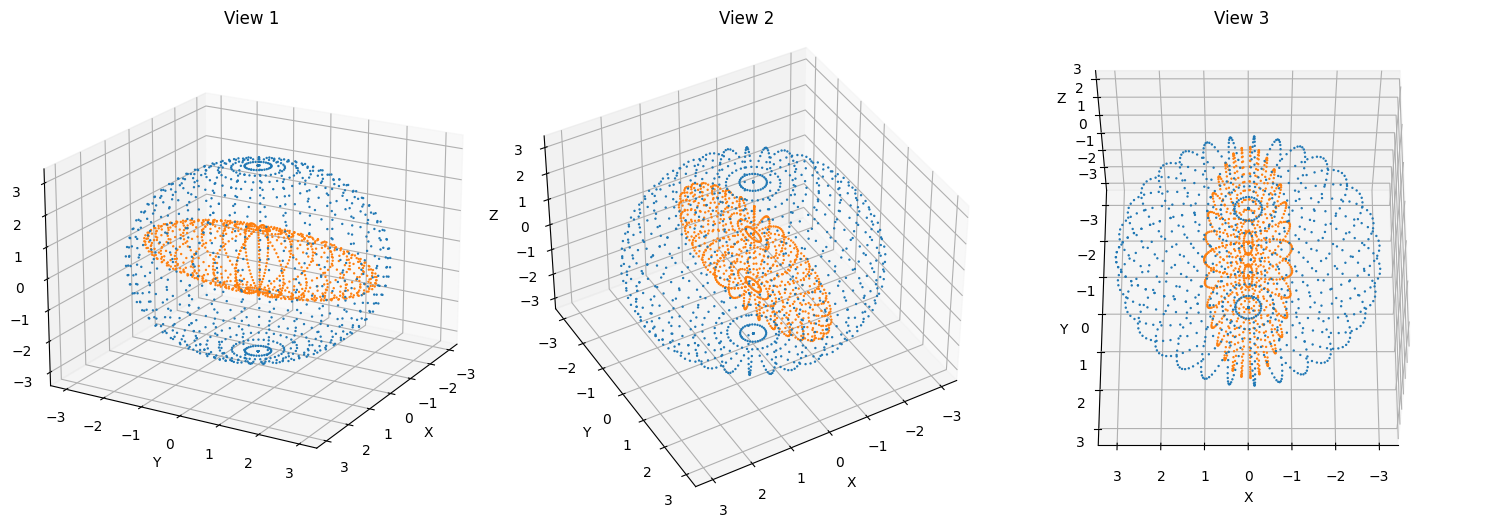

In [752]:
#t = torch.linspace(-3*torch.pi, 3*torch.pi, num_points).to(device).unsqueeze(1)

t1 = torch.linspace(-1*torch.pi, 1*torch.pi, 32)
t2 = torch.linspace(-2*torch.pi, 2*torch.pi, 32)
grid_t1, grid_t2 = torch.meshgrid((t1, t2), indexing='ij')
t = torch.stack((grid_t1, grid_t2), dim=-1).reshape(-1, 2).to(device)

points1 = generate_sphere(32, a = 3, b = 3, c = 3).to(device)[:,0:num_points,:]
points2 = generate_sphere(32, a = 1, b = 3, c = 1).to(device)[:,0:num_points,:]
#points3 = generate_sphere(32, a = 1, b = 1, c = 3).to(device)[:,0:num_points,:]


points = torch.concat((points1, points2,), dim=0).to(device)


#points = generate_data(num_points).to(device) 2D

plt.figure(figsize=(10, 10))
print(f"x shape:", t.shape)
print(f"points shape:", points.shape)
plot_data(points, mode = '3D')

  0%|          | 0/5000 [00:00<?, ?it/s]

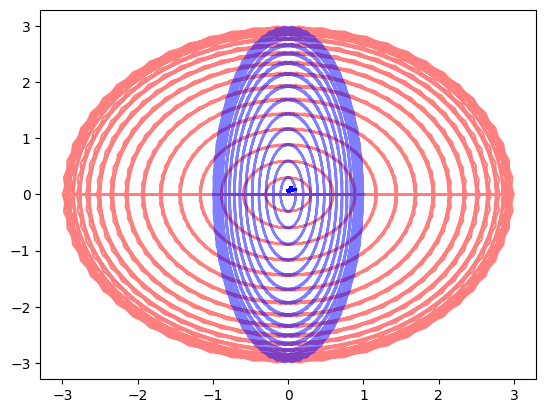

 10%|▉         | 481/5000 [00:02<00:22, 199.18it/s]

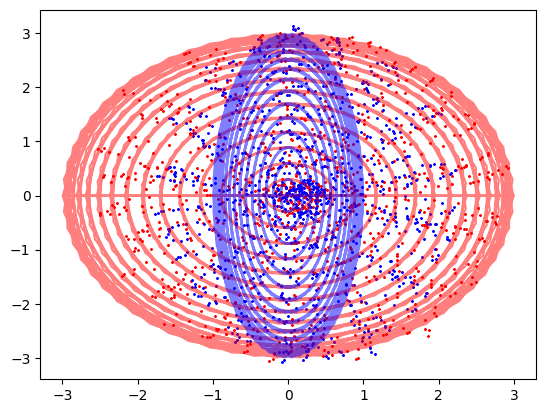

 20%|█▉        | 991/5000 [00:05<00:21, 187.62it/s]

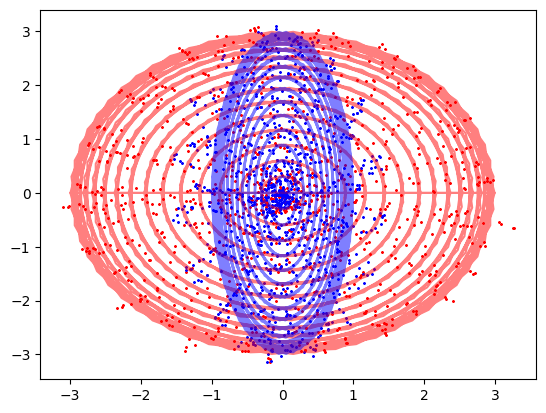

 30%|██▉       | 1497/5000 [00:07<00:16, 213.15it/s]

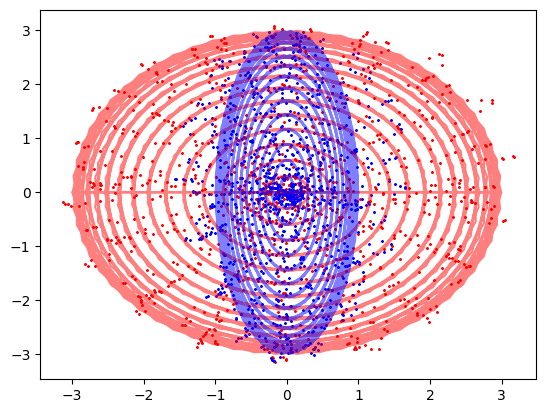

 40%|███▉      | 1980/5000 [00:10<00:16, 181.11it/s]

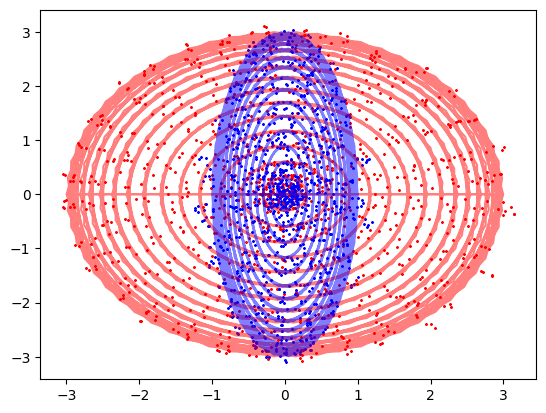

 50%|████▉     | 2491/5000 [00:12<00:11, 216.24it/s]

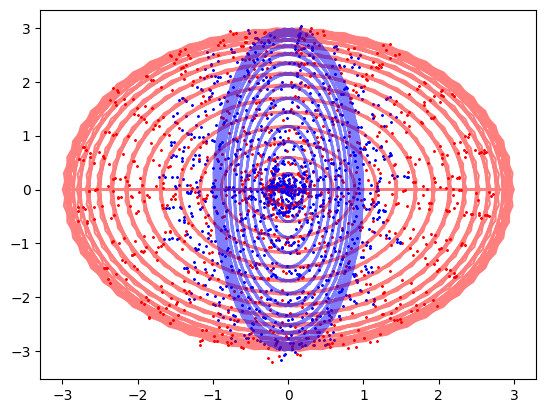

 60%|█████▉    | 2986/5000 [00:15<00:10, 197.14it/s]

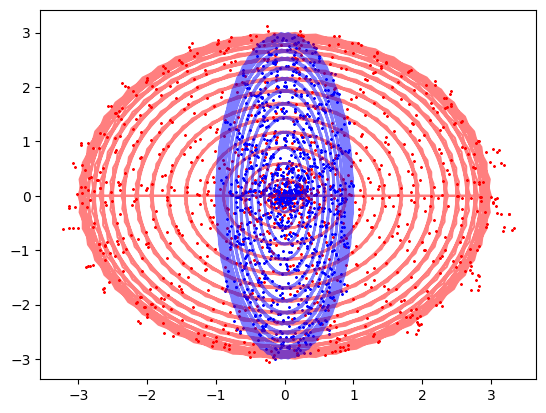

 70%|██████▉   | 3481/5000 [00:17<00:07, 216.76it/s]

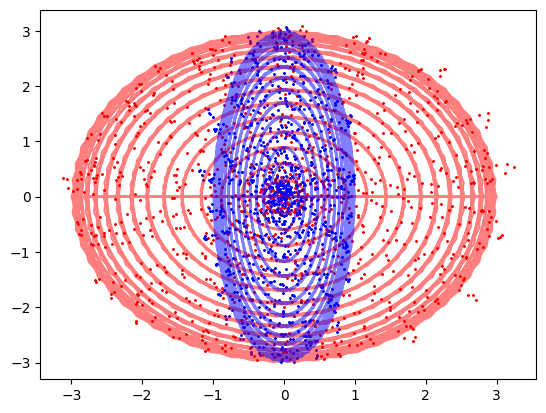

 80%|███████▉  | 3991/5000 [00:20<00:04, 222.08it/s]

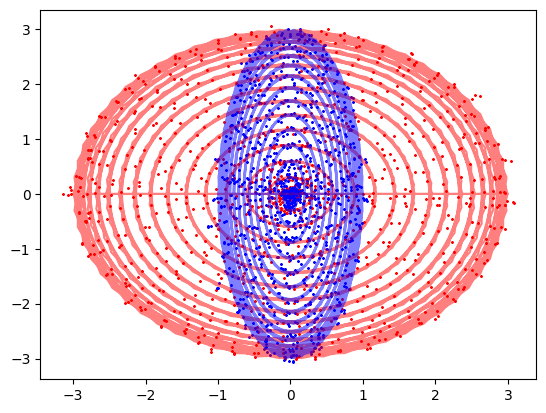

 90%|████████▉ | 4483/5000 [00:22<00:02, 224.25it/s]

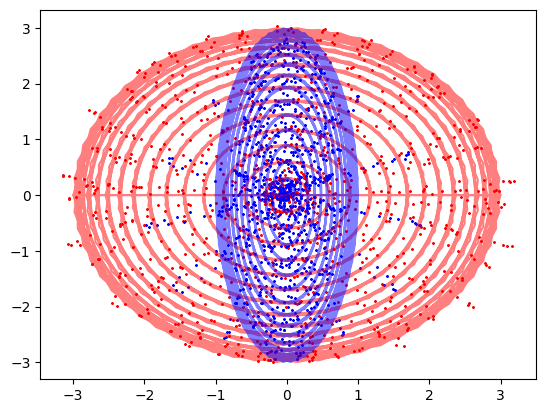

100%|██████████| 5000/5000 [00:25<00:00, 199.55it/s]


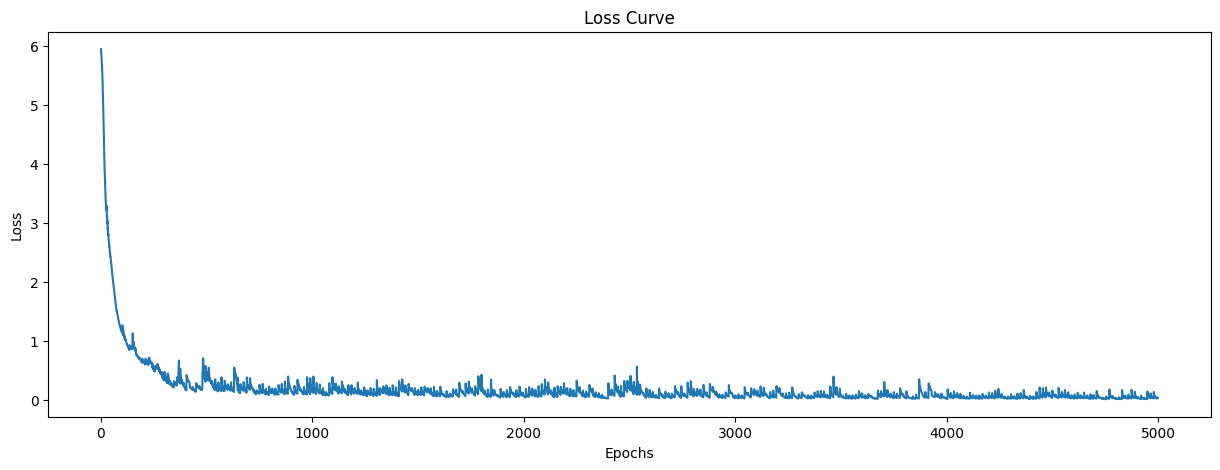

0.02976364456117153


In [733]:
H_t = H_theta(input_dim=zdim+xdim, output_dim=3).to(device)
optimizer = optim.Adam(H_t.parameters(), lr=lr)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)
losses = []

for e in tqdm(range(epochs)):
    with torch.no_grad():
        if e % staleness == 0:
            Zs = generate_NN_latent_functions(num_Z_samples, xdim, zdim, lambda_value=1)
            Zxs = torch.empty((num_Z_samples, num_points, zdim+xdim)).to(device)


            
            for i, Z in enumerate(Zs):
                Z = Z.to(device)
                Zx = Z(t)
                Zx = torch.cat((Zx, t), dim = 1)
                Zxs[i] = Zx
            # print(Zxs.shape)
            # print("Standard Dev", Zxs[:,0,:].std(dim=0))
            # print("min, max", Zxs[:,0,:].min(dim=0), Zxs[:,0,:].max(dim=0))
            generated = H_t(Zxs) #[30, 1024, 2]
            
            
            generated = generated.to(device)

            #points [2,1024,2]
            imle_nns = torch.tensor([find_nns(d, generated) for d in points], dtype=torch.long)
            imle_nn_z = [Zs[idx] for idx in imle_nns]
    
    
            imle_transformed_points = torch.empty((points.shape[0], num_points, zdim+xdim)).to(device)
            for i, model in enumerate(imle_nn_z):
                model = model.to(device)
                Zx = model(t)
                Zx = torch.cat((Zx, t), dim = 1)
                imle_transformed_points[i] = Zx
                
    outs = H_t(imle_transformed_points)
    optimizer.zero_grad()
    if e%500 == 0:
        outs_disp = outs.to(device='cpu').detach().numpy()
        points_disp = points.to(device='cpu').detach().numpy()
        for i in range(1):
            plt.plot(points_disp[0, :, 0], points_disp[0, :, 1], c='red', alpha = 0.5)
            plt.plot(points_disp[1, :, 0], points_disp[1, :, 1], c='blue', alpha = 0.5)
            plt.scatter(outs_disp[0, :, 0], outs_disp[0, :, 1], s=1.5, c='red', marker='*')
            plt.scatter(outs_disp[1, :, 0], outs_disp[1, :, 1], s=1.5, c='blue', marker='*')

        plt.show()
        
    loss = f_loss(outs, points)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    #scheduler.step()

plt.figure(figsize=(15, 5))
plt.plot(losses)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()
print(losses.pop())

In [734]:
points1 = points1.to('cpu').detach().numpy()
points2 = points2.to('cpu').detach().numpy()
# points3 = points3.to('cpu').detach().numpy()
# points4 = points4.to('cpu').detach().numpy()

In [735]:
points = points.to('cpu').detach().numpy()

In [736]:
t1 = torch.linspace(-1*torch.pi, 1*torch.pi, 32)
t2 = torch.linspace(-2*torch.pi, 2*torch.pi, 32)
grid_t1, grid_t2 = torch.meshgrid((t1, t2), indexing='ij')
t = torch.stack((grid_t1, grid_t2), dim=-1).reshape(-1, 2).to(device)

In [737]:
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(projection='3d')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title(f'3D Sphere - Output')
# t = torch.linspace(torch.pi-0.2, 3*torch.pi, num_points).to(device).unsqueeze(1)
# num_samples = 50
# Zs = generate_NN_latent_functions(num_samples, xdim, zdim)
# for i in range(num_samples):
#     # plt.scatter(points[0, :, 0].to('cpu').detach().numpy(), points[0, :, 1].to('cpu').detach().numpy())
#     # plt.scatter(points[1, :, 0].to('cpu').detach().numpy(), points[1, :, 1].to('cpu').detach().numpy())
    
#     Z = Zs[i].to(device)(t)
#     Z = torch.cat((Z, t), dim=1)
#     out = H_t(Z).to('cpu').detach().numpy()
    
#     plt.plot(out[:, 0], out[:, 1],alpha=0.8)
#     #plt.plot(out[:, 0], out[:, 1], alpha=1.0)


#     # Plot points1, points2, and points3 after the loop to ensure they are on top

#     plt.plot(points[0, :, 0], points[0, :, 1], alpha=0.3)
#     plt.plot(points[1, :, 0], points[1, :, 1], alpha=0.3)
#     #plt.plot(points3[0, :, 0], points3[0, :, 1], alpha=0.3)

# plt.show()


In [738]:
from vedo import *
import torch

samples_n = 50
outputs = torch.empty((samples_n, num_points, 3))

# Assuming a grid with n columns
n_columns = 10
n_rows = (samples_n + n_columns - 1) // n_columns  # Calculate the number of rows needed

for i in range(samples_n):
    Zs = generate_NN_latent_functions(1, xdim, zdim)[0].to(device)
    Z = Zs(t)
    Z = torch.cat((Z, t), dim=1)
    out = H_t(Z)
    outputs[i] = out

print("Output shape", outputs.mean(dim=1))

def save_obj_file(vertices, file_path, translation):
    with open(file_path, 'w') as file:
        file.write("# Wavefront OBJ file\n")
        for vertex in vertices:
            translated_vertex = vertex + torch.tensor(translation)
            file.write(f"v {translated_vertex[0]} {translated_vertex[1]} {translated_vertex[2]}\n")

def tensor_to_obj_files(tensor, base_file_path, n_columns):
    num_objects = tensor.shape[0]
    for i in range(num_objects):
        vertices = tensor[i]
        # Calculate the row and column for the current index
        row = i // n_columns
        col = i % n_columns
        # Translation based on row and column to arrange in a grid
        translation = (col * 10, row * 10, 0)  # Adjust spacing as needed (10 units here)
        file_path = f"{base_file_path}_{i+1}.obj"
        save_obj_file(vertices, file_path, translation)

# Define the base file path (without extension and index)
base_file_path = 'C:/Users/rajsh/Desktop/Human_Pose_Generation/ProvNERF Pose Generation/3D_intermediate/vertex_object'

# Convert tensor to .obj files with rectangular grid separation
tensor_to_obj_files(outputs, base_file_path, n_columns)


Output shape tensor([[ 1.9466e-02,  3.4428e-02, -1.4921e-01],
        [-4.1880e-03,  5.1012e-03, -7.1359e-02],
        [-3.6029e-02,  1.8481e-02,  6.4699e-02],
        [-1.2091e-02,  1.9131e-02, -2.3904e-01],
        [ 1.9644e-02,  4.0963e-03, -8.2532e-02],
        [-3.8428e-02, -1.1058e-02, -1.3758e-01],
        [ 1.6883e-02,  2.6386e-03,  2.5085e-01],
        [ 1.1522e-02,  2.0812e-02,  2.0272e-01],
        [ 1.3594e-02,  7.7879e-03,  2.6001e-01],
        [-4.8560e-02, -1.6888e-02,  8.5276e-02],
        [ 1.5695e-03, -8.6681e-03,  2.3386e-02],
        [-4.1917e-02, -1.0040e-02, -2.2975e-02],
        [-6.2993e-03, -4.3398e-03, -2.6772e-01],
        [-2.1920e-02,  6.5875e-03, -1.4419e-01],
        [-1.0003e-02, -1.0444e-02,  6.9220e-02],
        [ 9.3757e-03,  1.3166e-02, -1.9921e-01],
        [ 3.8661e-02,  2.4200e-02,  1.9289e-01],
        [-2.4533e-02, -9.2765e-03, -8.9279e-02],
        [ 2.3291e-02,  1.0139e-03,  8.3061e-03],
        [-1.0830e-02,  3.5997e-03,  2.1605e-01],
       